# Lloyd-Max quantization

* Minimizes the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) of the quantization error, i.e., the expectation of the power of the quantization error, i.e. 
\begin{equation}
 D = \text{E}[(\mathbf{x}-\mathbf{y})^2],
\end{equation}
where $D$ is the distortion generated by the quantizer, $\mathbf{x}$ is the original signal, and $\mathbf{y}$ is the reconstructed signal.
* The PDF (in the analog case) or the histogram (digital signals) is required. The density of quantization bins is higher in those parts of the input dynamic range where the probability of the samples is also higher.
* The quantizer must determine the decision levels, and the representation levels.
* Inside of a bin (quantization step), the PDF/histogram is supposed to be constant. *For this reason, we select the representation level of each bin just in the middle point. This is the *


## Adaptive quantization using the PDF
In the continuous case, if $M$ is the number of bins, the distortion can be expressed by
\begin{equation}
D = \sum_{i=1}^{M}\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}(\mathbf{x}-\mathbf{c}_i)^2P(x)dx,
\end{equation}
where $\mathbf{b}_i$ is the upper decision level of the $i$-th bin, $\mathbf{c}_i$ is the representation level for the $i$-th bin, and $P(x)=f_\mathbf{x}(x)$ is the probability of finding $x$ in the signal (considered as a random variable) $\mathbf{x}$.

To minimize $D$ we must solve
\begin{equation}
\frac{\partial D}{\partial \mathbf{c}_i} = 0 = -\sum_{i=1}^M\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
which boilds down to
\begin{equation}
= -\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
because $\mathbf{c}_i$ is only used in one of the bins. We continue
\begin{equation}
= 2\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx - 2\mathbf{c}_i\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx.
\end{equation}
Therefore:
\begin{equation}
\mathbf{c}_i = \frac{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx}{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx},\tag{1}
\end{equation}
i.e., the representation level $\mathbf{c}_i$ for each bin is the centroid of the probability mass in that bin. Notice that, in order to avoid a division by 0, at least one one sample must belong to each bin.

Unfortunately, such equation express that, to find the representation levels $\mathbf{c}_i$, we must determine first the decision levels $\mathbf{b}_i$. For computing them, we can now minimize $D$ respect to $\mathbf{b}_i$:
\begin{equation}
\frac{\partial D}{\partial \mathbf{b}_i} = 0,
\end{equation}
which, supposing that the bins are small enough to consider that the probability of the values of $\mathbf{x}$ is constant inside of each bin, ends up in that:
\begin{equation}
\mathbf{b}_i = \frac{\mathbf{c}_i+\mathbf{c}_{i+1}}{2},\tag{2}
\end{equation}
a result quite logical under such supposition.

## Computation of the representation levels.

Unfortunately, Equations (1) and (2) are mutually dependent. However, they can be used to compute $\{\mathbf{y}_k\}_{k=1}^M$ and $\{\mathbf{b}_k\}_{k=0}^M$ using the following iterative algorithm:

0. Define $\epsilon>0$.
1. Initialize $\mathbf{c}_k$ /* centroids */ at random.
2. Let $\mathbf{previous\_b}=\{\mathbf{previous\_d}_k\}_{k=0}^M=0$ /* boundaries */.
2. While $ max(|\mathbf{previous\_b}-\mathbf{b}|) > \epsilon$:
    1. $\mathbf{previous\_b}\leftarrow \mathbf{b}$.
    1. Compute the boundary (decision) levels $\mathbf{b}$ using Eq. (2).
    2. Update the centroids (representation levels) $\mathbf{c}$ using Eq. (1).

In [1]:
import numpy as np
from scipy.ndimage import uniform_filter1d
uniform_filter1d([2.0, 8, 0, 4, 1, 9, 9.0, 0], size=2, origin=-1)
uniform_filter1d([0, 128, 256], size=2, origin=-1)[:-1]
print(uniform_filter1d([64, 192], size=2, origin=-1)[:-1])
print(uniform_filter1d([64, 192], size=2, mode="nearest"))

[128]
[ 64 128]


In [32]:
from scipy.ndimage import center_of_mass
x = np.array([1,2,3,4,5])
center_of_mass(x)

x = np.array([1,1,1,1,1])
center_of_mass(x)[0]

2.0

In [3]:
def compute_boundaries(c):
    b = uniform_filter1d(c, size=2, origin=-1)[:-1]
    b = np.concatenate(([0],b,[256]))
    #print('y', y, 'b', b)
    return b

In [51]:
def compute_centroids(b, P, M):
    c = []
    bin_size = P.size//M
    print("bin_size", bin_size)
    for i in range(M):
        b_i = i*bin_size
        b_i_1 = (i+1)*bin_size
        print("b_i", b_i, "b_i_1", b_i_1)
        mass = np.sum([j*P[j] for j in range(b_i, b_i_1)])
        total_counts_in_bin = np.sum([P[j] for j in range(b_i, b_i_1)])
        #if total_counts_in_bin > 0:
        centroid = mass/total_counts_in_bin
        print("1", centroid, b_i, b_i_1)
        centroid = center_of_mass(b_i*P[b_i:b_i_1])[0]
        print("2", centroid)
        #else:
        #    centroid = mass/bin_size
        c.append(centroid)
    #print('>c', np.array(c))
    return np.array(c)

In [52]:
def compute_levels(P, epsilon, max_iters, M, min_val, max_val):
    initial_boundaries = np.linspace(min_val, max_val + 1, M + 1)
    initial_centroids = 0.5 * (initial_boundaries[1:] + initial_boundaries[:-1])
    #initial_centroids = np.concatenate(([0], initial_centroids))
    c = initial_centroids
    #print('c', c)
    b = initial_boundaries
    print('b', b)
    prev_b = np.zeros(b.size)
    print('prev_b', prev_b)
    #print(M)
    for j in range(max_iters):
        print('j', j)
        prev_b[:] = b
        b = compute_boundaries(c)
        max_abs_error = np.max(np.abs(prev_b-b))
        print("max_abs_error", max_abs_error)
        if (j>0) and (max_abs_error <= epsilon):
            break
        c = compute_centroids(b, P, M)
    return b, c

In [53]:
P = np.ones(256) # Counts for uniform distribution
#P = np.random.randint(low=0, high=2000, size=256)
epsilon = 1e-5
max_iters = 100
min_val = 0
max_val = 255
M = 2
compute_levels(P, epsilon, max_iters, M, min_val, max_val)

b [  0. 128. 256.]
prev_b [0. 0. 0.]
j 0
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 1
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 2
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 3
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 4
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 5
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 6
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 7
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 8
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 1

max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 84
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 85
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 86
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 87
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 88
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 89
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 90
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63.5
j 91
max_abs_error nan
bin_size 128
b_i 0 b_i_1 128
1 63.5 0 128
2 nan
b_i 128 b_i_1 256
1 191.5 128 256
2 63

(array([  0.,  nan, 256.]), array([ nan, 63.5]))

## Quantize an image

In [7]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [8]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

/home/vruiz/repos/image_IO ... 
Ya está actualizado.


In [9]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

/home/vruiz/repos/information_theory ... 
Ya está actualizado.


In [10]:
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/information_theory/information.py .

In [11]:
import LloydMax_quantization as quantization
import image_1 as gray_image
import os
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.utils import shuffle
import numpy as np
import distortion

In [12]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/circle/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
!ls -l {fn}

# Quantizer selection
#quantizer = quantization.LloydMax_Quantizer

n_clusters = 4  # Number of bins
N_tries = 4  # Number of times K-means is run (if the centroids are init at random)

#N_bins = range(2, 128, 1)
#N_bins = [2, 4, 8, 16, 32] #range(2, 128, 1)
#N_bins = [8]

gray_image.write = gray_image.debug_write

total 148
-rw-r--r-- 1 vruiz vruiz 151199 feb 18  2022 000.png


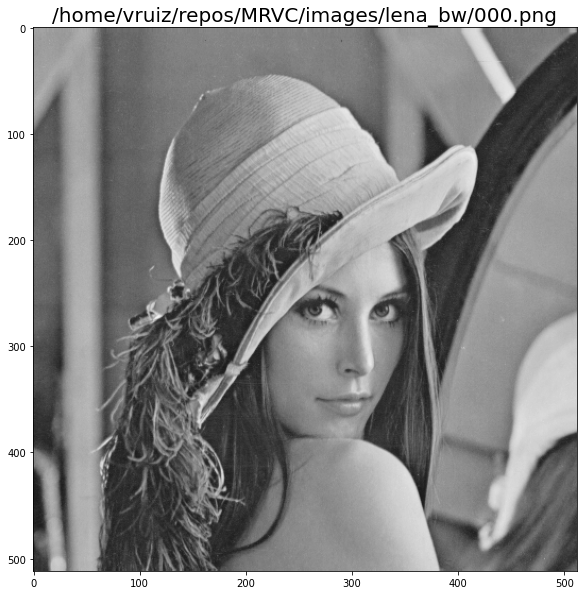

In [13]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

In [14]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
histogram[histogram==0] = 1
print(histogram, bin_edges)
print(len(histogram))

[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    7   22
   28   63   93  135  177  224  306  420  508  607  778  922 1082 1279
 1429 1642 1756 1846 2038 2066 2007 2081 2053 2039 1969 1846 1741 1673
 1549 1478 1289 1249 1193 1026  959  948  910  868  786  801  771  776
  848  812  820  801  880  903  850  890  938  935  916  924  847  951
  935  965  994 1015 1072 1108 1124 1224 1194 1346 1413 1557 1628 1791
 1853 2105 1930 1899 1941 1840 1763 1737 1588 1498 1466 1336 1369 1389
 1363 1442 1381 1336 1409 1464 1544 1517 1626 1789 1790 1878 2061 2097
 2311 2300 2385 2483 2390 2262 2235 2116 1993 1858 1929 1889 2040 2128
 2270 2270 2341 2433 2466 2409 2214 2340 2285 2202 2314 2327 2374 2611
 2723 2690 2673 2493 2391 2286 2062 1846 1769 1628 1454 1403 1370 1247
 1201 1241 1139 1187 1350 1242 1225 1184 1190 1236 1108  950  919  820
  790  681  626  619  641  691  647  664  726  815  825  912  926 1016
  876 

In [15]:
P = histogram
epsilon = 1e-5
max_iters = 100
min_val = 0
max_val = 255
M = 4
boundaries, centroids = compute_levels(P, epsilon, max_iters, M, min_val, max_val)

b [  0.  64. 128. 192. 256.]
prev_b [0. 0. 0. 0. 0.]
j 0
max_abs_error 0.0
bin_size 64
b_i 0 b_i_1 64
b_i 64 b_i_1 128
b_i 128 b_i_1 192
b_i 192 b_i_1 256
j 1
max_abs_error 12.680705039446224
bin_size 64
b_i 0 b_i_1 64
b_i 64 b_i_1 128
b_i 128 b_i_1 192
b_i 192 b_i_1 256
j 2
max_abs_error 0.0


In [16]:
print(boundaries)

[  0.          74.90222426 126.90860865 179.31929496 256.        ]


In [17]:
print(centroids)

[ 49.26993937 100.53450914 153.28270817 205.35588175]


In [18]:
labels = np.searchsorted(boundaries, img)

In [19]:
print(labels.shape)

(512, 512)


In [20]:
print(np.unique(labels))

[1 2 3 4]


In [21]:
print(len(np.unique(labels)))

4


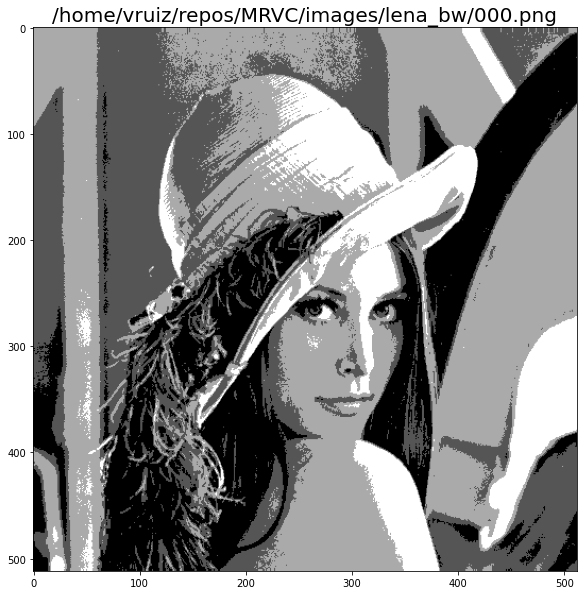

In [22]:
gray_image.show_normalized(labels, fn + "000.png")

In [ ]:
!pip install https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip

## Test K-means

In [ ]:
from sklearn.cluster import KMeans

X = np.asarray([[1, 2], [1, 4], [1, 0],
                [4, 2], [4, 4], [4, 0]])

clusterer = KMeans(n_clusters=2, random_state=0)
#clusterer.fit(X)
Y = clusterer.fit_transform(X)
print("labels =", clusterer.labels_)
clusterer.predict([[0,0], [4,4]])
print("centers =", clusterer.cluster_centers_)
print("inertia =", clusterer.inertia_)
print(X, Y)
#clusterer.get_feature_names_out()
#clusterer.get_params()
clusterer.score(Y)

## Test K-medoids

In [ ]:
from sklearn_extra.cluster import KMedoids
import numpy as np
import math

def MSE(x, y):
    d = x-y
    dd = d*d
    #print(x, y, x.shape, y.shape)
    #return math.sqrt(np.sum(dd)/len(dd))
    return np.sum(dd)/len(dd)

def lagrangian(x, y):
    return math.abs(x - y)

X = np.asarray([[1, 2], [1, 4], [1, 0],
                [4, 2], [4, 4], [4, 0]])

#clusterer = KMedoids(n_clusters=2, random_state=0, metric=MSE).fit(X)
clusterer = KMedoids(n_clusters=2, random_state=0).fit(X)
print("labels =", clusterer.labels_)
clusterer.predict([[0,0], [4,4]])
print("centers =", clusterer.cluster_centers_)
print("inertia =", clusterer.inertia_)
print(X, Y)
#clusterer.get_feature_names_out()
#clusterer.get_params()
#clusterer.score(Y)

KMeans computes centroids. KMedoids selects the inputs closest to the centroids. [KMedoids is related to the KMeans algorithm. While KMeans tries to minimize the within cluster sum-of-squares, KMedoids tries to minimize the sum of distances between each point and the medoid of its cluster. The medoid is a data point (unlike the centroid) which has the least total distance to the other members of its cluster.](https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html#k-medoids)

## Color Vector Quantization using K-means

In [ ]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Color Vector Quantization using K-medoids

In [ ]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMedoids(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Medoids)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Lloyd-Max quantization (of a gray-scaled image) using K-medoids

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 8

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) #/ 255
print(china.shape)
china = (( china[...,0] + china[...,1] + china[...,0] ) / 3).astype(np.uint8)

# Load Image and transform to a 2D numpy array.
w, h = original_shape = tuple(china.shape)
image_array = np.reshape(china, w * h)

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000).reshape(-1, 1)
kmeans = KMedoids(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array.reshape(-1, 1))
print(f"done in {time() - t0:0.3f}s.")
print(np.unique(labels))

codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
#labels_random = pairwise_distances_argmin(codebook_random, image_array.reshape(-1, 1), axis=0)
#print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Medoids)")
y = recreate_image(kmeans.cluster_centers_, labels, w, h)
print(np.unique(y))
plt.imshow(y)

#plt.figure(3)
#plt.clf()
#plt.axis("off")
#plt.title(f"Quantized image ({n_colors} colors, Random)")
#plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Voronoi diagram of the hand-written digits using K-means

In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Voronoi diagram of the hand-written digits using K-medoids

In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

#from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids as KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(n_clusters=n_digits, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(n_clusters=n_digits, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(n_clusters=n_digits)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(n_clusters=n_digits)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-medoids clustering on the digits dataset (PCA-reduced data)\n"
    "Centers are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Using a lagrangian $J =D+\lambda R$ distance metric

[The use of a data point to represent each cluster’s center allows the use of any distance metric for clustering.](https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html#k-medoids)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
import math

def entropy(sequence_of_symbols):
    assert sequence_of_symbols.ndim == 1
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    _entropy = 0.
    for i in probs:
        _entropy -= i * math.log(i, 2)

    return _entropy

_lambda = 1.0 # This represents a slope and therefore, the dynamic ranges of the axis R and D are relevant

def lagrangian(x, y):
    distortion = abs(x - y)
    return distortion
    #rate = math.log(np.sum(abs(x-y)) + 1)
    #return distortion + _lambda * rate

def lagrangian(x, y):
    d = x-y
    dd = d*d
    #print(x, y, x.shape, y.shape)
    #return math.sqrt(np.sum(dd)/len(dd))
    distortion = math.sqrt(np.sum(dd)/len(dd)) # dd is an array of 3 components (RGB)
    rate = math.log(np.sum(abs(d)) + 1)
    #print(np.sum(abs(x-y)), rate, x.shape, y.shape)
    return distortion + _lambda * rate

n_colors = 8

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMedoids(n_clusters=n_colors, random_state=0, metric=lagrangian).fit(image_array_sample)
#kmeans = KMedoids(n_clusters=n_colors, random_state=0).fit(image_array_sample)

print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Medoids)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Quantizing a gray-scaled image

## Using K-means

In [ ]:
from sklearn.cluster import KMeans

def quantize_using_kmeans(img, N_bins=4):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMeans(n_clusters=N_bins)
    clusterer.fit(flatten_img)
    centroids = clusterer.cluster_centers_.squeeze().astype(np.uint8)  # Centroids
    print(centroids)
    k = clusterer.labels_.astype(np.uint8)  # Labels of the centroids
    y = centroids[k]
    y.shape = img.shape
    k.shape = img.shape
    return k, y

N_bins = 4

k, y = quantize_using_kmeans(img, N_bins=N_bins)
_distortion = distortion.RMSE(img, y)
print("Used quantization indexes:", np.unique(k))
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

## Using K-medoids and (default) Euclidean distance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 4

# Load the Summer Palace photo
china = img # load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) #/ 255
print(china.shape)
#china = (( china[...,0] + china[...,1] + china[...,0] ) / 3).astype(np.uint8)

# Load Image and transform to a 2D numpy array.
w, h = original_shape = tuple(china.shape)
image_array = np.reshape(china, w * h)

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000).reshape(-1, 1)
kmeans = KMedoids(init="k-medoids++", n_clusters=n_colors, random_state=0).fit(image_array_sample)
#kmeans = KMedoids(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array.reshape(-1, 1))
print(f"done in {time() - t0:0.3f}s.")
print(np.unique(labels))

codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
#labels_random = pairwise_distances_argmin(codebook_random, image_array.reshape(-1, 1), axis=0)
#print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


gray_image.show(china, "Original image (96,615 colors)")
y = recreate_image(kmeans.cluster_centers_, labels, w, h)
print(np.unique(y))
gray_image.show(y, f"Quantized image ({n_colors} colors, K-Medoids)")

## Using K-medoids (again) and Euclidean distance

In [ ]:
def quantize_using_kmedoids(img, N_bins=8):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMedoids(init="k-medoids++", n_clusters=N_bins)
    #clusterer = KMeans(n_clusters=N_bins)
    image_array_sample = shuffle(flatten_img, random_state=0, n_samples=1_000)
    clusterer.fit(image_array_sample)
    k = clusterer.predict(flatten_img)
    y = clusterer.cluster_centers_[k]
    centroids = clusterer.cluster_centers_
    k.shape = img.shape
    y.shape = img.shape
    return k, y
    
N_bins = 4

k, y = quantize_using_kmedoids(img, N_bins=N_bins)
_distortion = distortion.RMSE(img, y)
print("Used quantization indexes:", np.unique(k))
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

## Sort the quantization indexes

In [ ]:
def sort_indexes(clusterer):
    centers = clusterer.cluster_centers_.squeeze() # Don't copy data (it's only a view)
    idx = np.argsort(clusterer.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(centers.size)
    argsort_lut = np.argsort(lut)
    sorted_centroids = centers[argsort_lut]
    sorted_labels = lut[clusterer.labels_]
    centers[:] = sorted_centroids
    clusterer.labels_ = sorted_labels
    return clusterer

def quantize_using_sorted_kmeans(img, N_bins=16):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMeans(n_clusters=N_bins)
    clusterer.fit(flatten_img)
    clusterer = sort_indexes(clusterer)
    centroids = clusterer.cluster_centers_.squeeze().astype(np.uint8)  # Centroids
    k = clusterer.labels_.astype(np.uint8)  # Labels of the centroids
    y = centroids[k]
    y.shape = img.shape
    k.shape = img.shape
    return k, y

N_bins = 16

k, y = quantize_using_kmeans(img, N_bins=N_bins)
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
k, y = quantize_using_sorted_kmeans(img, N_bins=N_bins)
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")

In [ ]:
def quantize_using_sorted_kmedoids(img, N_bins=8, N_samples=0):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMedoids(init="k-medoids++", n_clusters=N_bins)
    if N_samples > 0:
        image_array_sample = shuffle(flatten_img, random_state=0, n_samples=N_samples)
    else:
        image_array_sample = flatten_img
    clusterer.fit(image_array_sample)
    clusterer = sort_indexes(clusterer)
    k = clusterer.predict(flatten_img)
    y = clusterer.cluster_centers_[k]
    centroids = clusterer.cluster_centers_
    k.shape = img.shape
    y.shape = img.shape
    return k, y, clusterer

In [ ]:
N_bins = 16

k, y, _ = quantize_using_kmedoids(img, N_bins=N_bins, N_samples=1_000)
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
k, y, _ = quantize_using_sorted_kmedoids(img, N_bins=N_bins, N_samples=1_000)
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")

## Use the lagrangian $J=D+\lambda R$ distance metric (in K-medoids)
K-means (at least the implementation of scikit-learn) can only use the Euclinean Distance :-/

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

_lambda = 40.0 # The dynamic range of the related metrics must be considered

_max_rate = 0.0
_max_distortion = 0.0

def lagrangian(x, y):
    global _lambda, _max_rate, _max_distortion
    d = x[0] - y[0]
    #dd = d*d
    #distortion = math.sqrt(dd/len(dd))
    #distortion = dd
    distortion = abs(d)
    #distortion = np.linalg.norm(x-y)
    #distortion = euclidean_distances(x.reshape(-1, 1), y.reshape(-1, 1))
    if distortion > _max_distortion:
        _max_distortion = distortion
    rate = math.log(abs(d) + 1)
    if rate > _max_rate:
        _max_rate = rate
    #print(_lambda, distortion)
    return distortion
    return distortion + _lambda * rate

def quantize_using_sorted_kmedoids_with_metric(img, N_bins=8, N_samples=0, metric=lagrangian):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMedoids(init="k-medoids++", n_clusters=N_bins, metric=metric)
    if N_samples > 0:
        image_array_sample = shuffle(flatten_img, random_state=0, n_samples=N_samples)
    else:
        image_array_sample = flatten_img
    clusterer.fit(image_array_sample)
    clusterer = sort_indexes(clusterer)
    k = clusterer.predict(flatten_img)
    y = clusterer.cluster_centers_[k]
    centroids = clusterer.cluster_centers_
    k.shape = img.shape
    y.shape = img.shape
    return k, y, clusterer

In [ ]:
N_bins = 16
k, y, _ = quantize_using_sorted_kmedoids_with_metric(img, N_bins=16, N_samples=1_000, metric=lagrangian)
print(f"max_distortion={_max_distortion}, max_rate={_max_rate}")
print("Used quantization indexes:", np.unique(k))
_distortion = distortion.RMSE(img, y)
gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

In [ ]:
# Reduce image to guarantee that all pixels are used during the training

def get_representation_levels(clusterer):
    return clusterer.cluster_centers_.squeeze()

def compute_rate(k, n, clusterer):
    rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
    with open("/tmp/representation_levels.uint8", mode="wb") as f:
        representation_levels = get_representation_levels(clusterer)
        print(f"representation_levels={representation_levels}")
        representation_levels.tofile(f)
    rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
    return rate

import cv2
reduced_img = cv2.resize(img, (64, 64))

_lambda = 0

k, y, _ = quantize_using_sorted_kmedoids_with_metric(resized_img, N_bins=16, N_samples=0, metric=lagrangian)
print(f"max_distortion={_max_distortion}, max_rate={_max_rate}")
print("Used quantization indexes:", np.unique(k))
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y):>6.4f},\
      entropy={entropy(k.flatten()):>6.4}, rate={compute_rate(k, N_bins, _):>6.4}")

_lambda = 40

k, y, _ = quantize_using_sorted_kmedoids_with_metric(resized_img, N_bins=16, N_samples=0, metric=lagrangian)
print(f"max_distortion={_max_distortion}, max_rate={_max_rate}")
print("Used quantization indexes:", np.unique(k))
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y):>6.4f},\
      entropy={entropy(k.flatten()):>6.4}, rate={compute_rate(k, N_bins, _):>6.4}")

_lambda = 400

k, y, _ = quantize_using_sorted_kmedoids_with_metric(resized_img, N_bins=16, N_samples=0, metric=lagrangian)
print(f"max_distortion={_max_distortion}, max_rate={_max_rate}")
print("Used quantization indexes:", np.unique(k))
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y):>6.4f},\
      entropy={entropy(k.flatten()):>6.4}, rate={compute_rate(k, N_bins, _):>6.4}")

k, y, _ = quantize_using_sorted_kmedoids_with_metric(resized_img, N_bins=8, N_samples=0, metric=lagrangian)
print(f"max_distortion={_max_distortion}, max_rate={_max_rate}")
print("Used quantization indexes:", np.unique(k))
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y):>6.4f},\
      entropy={entropy(k.flatten()):>6.4}, rate={compute_rate(k, N_bins, _):>6.4}")

## Some previous results

    max_distortion=206.0, max_rate=5.332718793265369
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    [ 44.  54.  72.  85.  97. 105. 115. 126. 135. 145. 155. 163. 178. 194.
     205. 215.]
    lambda=   0, N_bins= 16, distortion=3.3491,      entropy= 3.927, rate=  3.67
    max_distortion=206.0, max_rate=5.332718793265369
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    [ 47.  55.  75.  93. 102. 108. 117. 127. 134. 144. 150. 157. 165. 178.
     194. 208.]
    lambda=  40, N_bins= 16, distortion=3.6668,      entropy= 3.963, rate= 3.758
    max_distortion=206.0, max_rate=5.332718793265369
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    [ 45.  52.  61.  75.  93. 100. 108. 121. 129. 143. 150. 156. 163. 177.
     194. 208.]
    lambda= 400, N_bins= 16, distortion=3.5672,      entropy= 3.971, rate= 3.719
    max_distortion=206.0, max_rate=5.332718793265369
    Used quantization indexes: [0 1 2 3 4 5 6 7]
    [ 49.  75.  99. 116. 129. 145. 158. 195.]
    lambda= 400, N_bins= 16, distortion=7.3055,      entropy= 2.962, rate= 2.766

    max_distortion=209.0, max_rate=5.3471075307174685
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=0, N_bins= 16, rate=3.6796875 bits/pixel, distortion=3.31710, entropy=3.917608170461749
    max_distortion=209.0, max_rate=5.3471075307174685
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=40, N_bins= 16, rate=3.666015625 bits/pixel, distortion=3.53522, entropy=3.9250249477707864
    max_distortion=209.0, max_rate=5.3471075307174685
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=4000, N_bins= 16, rate=3.736328125 bits/pixel, distortion=3.52021, entropy=3.966581293271344
    max_distortion=209.0, max_rate=5.3471075307174685
    Used quantization indexes: [0 1 2 3 4 5 6 7]
    _lambda=4000, N_bins=  8, rate=2.755859375 bits/pixel, distortion=7.39723, entropy=2.96753198946939

    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=0, N_bins= 16, rate=3.787109375 bits/pixel, distortion=3.36253, entropy=3.95136060621473
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=40, N_bins= 16, rate=3.73046875 bits/pixel, distortion=3.75159, entropy=3.9008265965939115
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=4000, N_bins= 16, rate=3.755859375 bits/pixel, distortion=3.59670, entropy=3.9622656631482345
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [0 1 2 3 4 5 6 7]
    _lambda=4000, N_bins=  8, rate=2.689453125 bits/pixel, distortion=7.46460, entropy=2.9417908530659456

    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=0, N_bins= 16, rate=3.66015625 bits/pixel, distortion=3.44023, entropy=3.8858449825573533
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=40, N_bins= 16, rate=3.685546875 bits/pixel, distortion=3.58201, entropy=3.9070442785597437
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
    _lambda=4000, N_bins= 16, rate=3.728515625 bits/pixel, distortion=3.60342, entropy=3.9285071340839655
    max_distortion=205.0, max_rate=5.327876168789581
    Used quantization indexes: [0 1 2 3 4 5 6 7]
    _lambda=4000, N_bins=  8, rate=2.796875 bits/pixel, distortion=7.04590, entropy=2.9820561942650836

If $\lambda=0$, and we minimize $J=D+\lambda R$, we are minimizing the distortion, only. If $\lambda=40$ (that must be selecting a point in the "middle" of the RD curve), the distortion should increase and the rate should decrease. 

## Check if the Euclidean distance is the same than RMSE

In [ ]:
_lambda = 0
k1, y1, clusterer1 = quantize_using_sorted_kmedoids_with_metric(resized_img, N_bins=16, metric=lagrangian)
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y1):>6.4f},\
      entropy={entropy(k1.flatten()):>6.4}, rate={compute_rate(k1, N_bins, clusterer1):>6.4}")
k2, y2, clusterer2 = quantize_using_sorted_kmedoids(resized_img, N_bins=16)
print(f"lambda={_lambda:>4}, N_bins={N_bins:>3}, distortion={distortion.RMSE(reduced_img, y2):>6.4f},\
      entropy={entropy(k2.flatten()):>6.4}, rate={compute_rate(k2, N_bins, clusterer2):>6.4}")

    [ 47.  57.  72.  84.  97. 105. 116. 126. 134. 144. 152. 161. 176. 191.
     203. 212.]
    lambda=   0, N_bins= 16, distortion=3.3937,      entropy= 3.934, rate= 3.717
    [ 45.  54.  68.  80.  94. 103. 114. 122. 129. 141. 151. 160. 172. 181.
     195. 209.]
    lambda=   0, N_bins= 16, distortion=3.4245,      entropy= 3.935, rate= 3.732


    [ 43.  50.  59.  73.  85.  96. 104. 114. 123. 131. 143. 152. 161. 177.
     195. 210.]
    lambda=   0, N_bins= 16, distortion=3.3585,      entropy= 3.956, rate= 3.699
    [ 47.  57.  72.  84.  96. 105. 118. 129. 139. 146. 155. 163. 178. 194.
     207. 217.]
    lambda=   0, N_bins= 16, distortion=3.3752,      entropy= 3.909, rate= 3.676


## Using the library

In [ ]:
input()

## Using (again) a lagrangian $J =D+\lambda R$ distance metric with the library

In [ ]:
def quantize_using_kmedoids(img, N_bins=4, _lambda=1.0):
    def lagrangian(x, y):
        d = x-y
        dd = d*d
        distortion = math.sqrt(dd/len(dd))
        rate = math.log(abs(d) + 1)
        return distortion + _lambda * rate

    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMedoids(init="k-medoids++", n_clusters=N_bins, metric=lagrangian)
    #clusterer = KMeans(n_clusters=N_bins)
    image_array_sample = shuffle(flatten_img, random_state=0, n_samples=1_000)
    print("Input pixels:", np.unique(image_array_sample))
    clusterer.fit(image_array_sample)
    k = clusterer.predict(flatten_img)
    y = clusterer.cluster_centers_[k]
    centroids = clusterer.cluster_centers_
    #print(centroids)
    k.shape = img.shape
    y.shape = img.shape
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
quantize_using_kmedoids(img, 4)

## Check is Euclidean distance is the same than RMSE

In [ ]:
quantize_using_kmedoids(img, 4, _lambda = 0)
def quantize_using_kmedoids(img, N_bins=8):
    flatten_img = img.reshape((-1, 1))  # flatten
    clusterer = KMedoids(init="k-medoids++", n_clusters=N_bins)
    #clusterer = KMeans(n_clusters=N_bins)
    image_array_sample = shuffle(flatten_img, random_state=0, n_samples=1_000)
    print("Input pixels:", np.unique(image_array_sample))
    clusterer.fit(image_array_sample)
    k = clusterer.predict(flatten_img)
    y = clusterer.cluster_centers_[k]
    centroids = clusterer.cluster_centers_
    #print(centroids)
    k.shape = img.shape
    y.shape = img.shape
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
quantize_using_kmedoids(img, 4)

## Using the library

In [ ]:
def RD_curve_sorted_labels(img, N_bins):
    points = []
    for n in N_bins:
        Q_step = 256//n
        Q = quantizer(img, Q_step=Q_step)
        y, k = Q.quan_dequan(img)
        print("Quantization indexes:", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        with open("/tmp/representation_levels.uint8", mode="wb") as f:
            Q.get_representation_levels().tofile(f)
        rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
        #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
        #    np.save(file=f, arr=Q.get_representation_levels())
        #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(k.shape[0]*k.shape[1]))
        #_distortion = distortion.RMSE(img, y)
        _distortion = distortion.RMSE(img, np.round(y).astype(np.uint8))
        gray_image.show_normalized(k, f"Quantization Indexes (N_bins={n})")
        #if n<16:
        #    plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        #    plt.show()
        points.append((rate, _distortion))
        print(f"N_bins={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points_sorted_labels = RD_curve_sorted_labels(img, N_bins)

In [ ]:
def quantize_using_kmeans(img, N_bins=8):
    Q_step = 256//N_bins
    Q = quantizer(img, Q_step)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
quantize_using_kmeans(img)

In [ ]:
def quantize_using_kmedoids(img, N_bins=8):
    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
quantize_using_kmedoids(img)

## Using (again) a lagrangian $J =D+\lambda R$ distance metric with the library

In [ ]:
def quantize_using_kmedoids(img, N_bins=8, _lambda=1.0):
    def lagrangian(x, y):
        d = x-y
        dd = d*d
        distortion = math.sqrt(dd/len(dd))
        rate = math.log(abs(d) + 1)
        return distortion + _lambda * rate
    
    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True, metric=lagrangian)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    #gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

quantize_using_kmedoids(img, 8, 0)
quantize_using_kmedoids(img, 8, 1)
quantize_using_kmedoids(img, 8, 1000)

In [ ]:
def quantize_using_kmedoids(img, N_bins=8, _lambda=1.0):
    def lagrangian(x, y):
        d = x-y
        dd = d*d
        distortion = math.sqrt(dd/len(dd))
        rate = math.log(abs(d) + 1)
        return distortion + _lambda * rate

    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True, metric=lagrangian)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    print(f"lambda={_lambda:>6.1f}, N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
    return y

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for _lambda in [0, 0.5, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]:
    if _lambda == 0:
        ax.imshow(img, cmap="gray")  # show an initial one first
        t = ax.annotate("original", (10,20))
    else:
        y = quantize_using_kmedoids(img, 8, _lambda)
        _distortion = distortion.RMSE(img, y)
        t = ax.annotate(f"lambda={_lambda} distortion={_distortion}", (10,20))
    im = ax.imshow(y, animated=True, cmap="gray")
    ims.append([im, t])

ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

## Test if $\lambda=0$ in $J=D+\lambda R$ equivals to using the Euclidean distance

In [ ]:
def quantize_using_kmedoids(img, N_bins=8, _lambda=1.0):
    def lagrangian(x, y):
        d = x-y
        dd = d*d
        distortion = math.sqrt(dd/len(dd))
        rate = math.log(abs(d) + 1)
        return distortion + _lambda * rate
    
    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True, metric=lagrangian)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    #gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

quantize_using_kmedoids(img, 8, 0)

def quantize_using_kmedoids(img, N_bins=8):
    
    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True, metric=lagrangian)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    gray_image.show_normalized(k, f"Quantization Indexes (N_bins={N_bins})")
    #gray_image.show(y, f"Reconstruction (N_bins={N_bins})")
    print(f"N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")

quantize_using_kmedoids(img, 8)
quantize_using_kmedoids(img, 8, 1000)

In [ ]:
x = np.arange(0, 128)   # start,stop,step
y = np.log(x + 1)
plt.plot(x, y)
plt.show()

In [ ]:
import math

def quantize_using_kmedoids(img, information_of_symbols, N_bins=8, _lambda=1.0):
    def lagrangian(x, y):
        d = x-y
        dd = d*d
        distortion = math.sqrt(dd/len(dd))
        rate = information_of_symbols[abs(d)] # We suppose that the histogram of <d> shows a symmetry centered at 0
        return distortion + _lambda * rate

    Q_step = 256//N_bins
    Q = quantizer(img, Q_step, use_medoid=True, metric=lagrangian)
    y, k = Q.quan_dequan(img)
    print("Used quantization indexes:", np.unique(k))
    _distortion = distortion.RMSE(img, y)
    print(f"lambda={_lambda:>6.1f}, N_bins={N_bins:>3}, distortion={_distortion:>6.1f}")
    return y

def symbols_information(sequence_of_symbols):
    assert sequence_of_symbols.ndim == 1
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    information_of_symbols = []
    for i in probs:
        information_of_symbols.append(-math.log(i, 2))

    return information_of_symbols

_lambda = 1.0

information_of_symbols = symbols_information(img.flatten())
print(information_of_symbols)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(information_of_symbol)

In [ ]:
len(information_of_symbols)

In [ ]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))

plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges[0:-1], histogram)